<a href="https://colab.research.google.com/github/rish4/Minor-Project/blob/main/VGG_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [2]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 5
batch_size = 32

In [3]:
# https://www.kaggle.com/moltean/fruits
train_path = '/content/drive/MyDrive/Cats and Dogs Dataset/training_set'
valid_path = '/content/drive/MyDrive/Cats and Dogs Dataset/test_set'

In [4]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [5]:
# useful for getting number of classes
folders = glob(train_path + '/*')

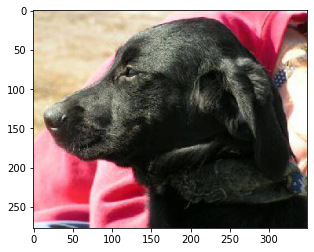

In [6]:
# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [7]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [9]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [11]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


In [12]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -103.939 max: 68.681694


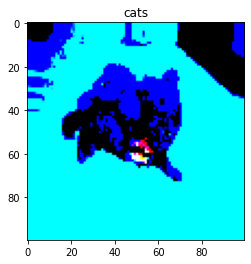

In [13]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [14]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [15]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
250/250 [==============================] - 1976s 8s/step - loss: 3.5536 - accuracy: 0.8008 - val_loss: 3.1001 - val_accuracy: 0.8196
Epoch 2/5
250/250 [==============================] - 1014s 4s/step - loss: 2.9398 - accuracy: 0.8369 - val_loss: 2.9364 - val_accuracy: 0.8342
Epoch 3/5
250/250 [==============================] - 1018s 4s/step - loss: 2.7088 - accuracy: 0.8505 - val_loss: 3.3813 - val_accuracy: 0.8342
Epoch 4/5
250/250 [==============================] - 1026s 4s/step - loss: 2.9158 - accuracy: 0.8426 - val_loss: 3.2484 - val_accuracy: 0.8427
Epoch 5/5
250/250 [==============================] - 1020s 4s/step - loss: 2.9058 - accuracy: 0.8450 - val_loss: 3.7151 - val_accuracy: 0.8337


In [17]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  import seaborn as sns
  f = sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')
  
  TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
  accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
  precision = TP / (TP+FP) # % positive out of all predicted positives
  recall =  TP / (TP+FN) # % positive out of all supposed to be positives
  specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
  f1 = 2*precision*recall / (precision + recall)
  stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
  print(stats_summary)

  return cm

Generating confusion matrix 8000
Found 8000 images belonging to 2 classes.
50
100
[Summary Statistics]
Accuracy = 85.88% | Precision = 86.35% | Recall = 85.22% | Specificity = 86.52% | F1 Score = 85.78%
[[3461  539]
 [ 591 3409]]


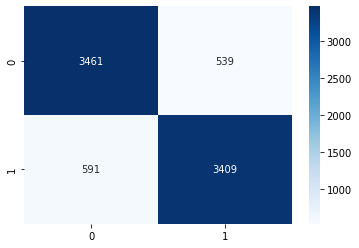

In [18]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)


Generating confusion matrix 2000
Found 2000 images belonging to 2 classes.
[Summary Statistics]
Accuracy = 85.70% | Precision = 86.28% | Recall = 84.90% | Specificity = 86.50% | F1 Score = 85.58%
[[865 135]
 [151 849]]


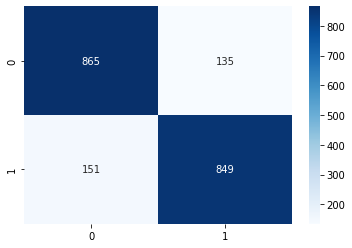

In [19]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

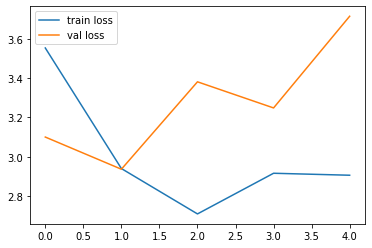

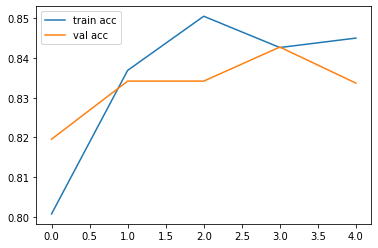

In [20]:
# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()